### Imports

In [215]:
import os
import numpy as np
import pandas as pd
import importlib
import re

import matplotlib.pyplot as plt

import findatree.io as io
import findatree.descriptions as descriptions

plt.style.use(r'C:\Repos\findatree\own.mplstyle')

# Dictionaries: species_name to ba and vice versa
species_id_to_name = descriptions.species_id_to_name()
species_name_to_id = descriptions.species_name_to_id()

### Definitions

In [374]:
# Directory: Processed tnr%.hdf5s
dir_hdf5 = r"C:\Data\lwf\processed\2020\hdf5"

# Directory: Plots
dir_plots = r"C:\Data\lwf\analysis\221028_veg-index\plots"

# Path to flight-log
path_log = r"C:\Data\lwf\Flugbuch_WZE-2020_digitalisiert.csv"

### Load all features and logbook

In [378]:
importlib.reload(io)

# Load all features as pd.DataFrame
df_original, params_df = io.allhdf5s_crowns_features_to_dataframe(dir_hdf5, crowns_type='crowns_human')

# Load logbook
log = pd.read_csv(path_log, sep=';', header=0)

####  Clean-up of features

In [405]:
# Copy original
df = df_original.copy()
print(f"{r'#crowns'} = {len(df)} (original)")

# Convert bhd_2020 column to float32 dtype
df.loc[:, 'bhd_2020'] = pd.to_numeric(df.bhd_2020, errors='coerce')
df.bhd_2020 = df.bhd_2020.astype(np.float32)

# Convert bk column to int32 dtype
df.loc[:, 'bk'] = pd.to_numeric(df.bk, errors='coerce')
df.bk = df.bk.astype(np.int32)

# Drop NaN containing rows
df = df.dropna(axis=0, how='any')   
print(f"{r'#crowns'} = {len(df)} (after removal: NaNs,  i.e. completely shadowed or dead)")

# Drop bk > 1
df = df[df.bk <= 1]
print(f"{r'#crowns'} = {len(df)} (after removal: bk > 1)")

# Drop kkl > 3
df = df[df.kkl <= 3]
print(f"{r'#crowns'} = {len(df)} (after removal: kkl > 3)")

# Drop area_bright/0.2**2 < 10
df = df[df.area_bright / 0.2**2 > 10]
print(f"{r'#crowns'} = {len(df)} (after removal: #(bright pixels) <= 10)")

# Drop perc5_ndre < 0
df = df[df.perc5_ndre > -1e-1]
print(f"{r'#crowns'} = {len(df)} (after removal: perc5_ndre < 1e-1)")


#crowns = 4254 (original)
#crowns = 4158 (after removal: NaNs,  i.e. completely shadowed or dead)
#crowns = 4127 (after removal: bk > 1)
#crowns = 4127 (after removal: kkl > 3)
#crowns = 4089 (after removal: #(bright pixels) <= 10)
#crowns = 4067 (after removal: perc5_ndre < 1e-1)


#### Assign weather conditions

In [406]:
tnrs = log.Traktnummer.values
weathers = log['Wetter-Code'].values
tnr_to_weather = dict([(tnr, weather) for tnr, weather in zip(tnrs, weathers)])

df['weather'] = [tnr_to_weather[tnr] for tnr in df.tnr]

print(f"#tnrs = {len(np.unique(df[df.weather == 0].tnr))} -> sunny")
print(f"#tnrs = {len(np.unique(df[df.weather == 1].tnr))} -> cloudy")
print(f"#tnrs = {len(np.unique(df[df.weather == 2].tnr))} -> mixed")
print()
print(f"#crowns = {np.sum(df.weather == 0)} -> sunny")
print(f"#crowns = {np.sum(df.weather == 1)} -> cloudy")
print(f"#crowns = {np.sum(df.weather == 2)} -> mixed")


#tnrs = 81 -> sunny
#tnrs = 47 -> cloudy
#tnrs = 22 -> mixed

#crowns = 2125 -> sunny
#crowns = 1293 -> cloudy
#crowns = 649 -> mixed


#### Assign families

In [509]:
importlib.reload(descriptions)

# Define families by patterns
family_patterns = [
    'Gemeine Kiefer',
    'Gemeine Fichte',
    'Rotbuche',
    'Traubeneiche|Stieleiche',
]
family_names = [
    'Kiefer',
    'Fichte',
    'Buche',
    'Eiche'
]

families = descriptions.species_groupby_families(family_patterns, family_names)
family_ids = descriptions.species_id_to_family_id(df.ba.values, families)

df = df.assign(
    family = family_ids,
    )

### Infos

#### Search: Pattern in column names

In [40]:
pattern = 'min'

cols = list(df.columns)
for col in cols:
    if bool(re.search(pattern, col, re.IGNORECASE)):
        print(col)

x_min_bbox
y_min_bbox
x_min_bbox_bright
y_min_bbox_bright


#### Info: Dataset

In [510]:
importlib.reload(descriptions)

descriptions.print_summary(
    df.tnr.values,
    df.ba.values,
    df.family.values,
    families,
)

Total number of crowns        : 4067
Mean number of crowns per tnr : 27.1
__________________________________________________

species_id| species_name                  | count
--------------------------------------------------
       134| Gemeine Kiefer                : 1424
       118| Gemeine Fichte                : 1215
        20| Rotbuche                      : 489
        48| Traubeneiche                  : 205
       100| Weißtanne                     : 192
        51| Stieleiche                    : 131
       116| Europäische Lärche            : 115
        22| Gemeine Esche                 : 53
        10| Gemeine Birke                 : 45
       136| Douglasie                     : 35
         5| Bergahorn                     : 32
         7| Schwarzerle                   : 27
       129| Schwarzkiefer                 : 22
        13| Hainbuche                     : 18
        36| Kirsche                       : 15
       117| Japanische Lärche             : 10
        53| 

### Plotting

#### Groupby: family, weather, sst

In [408]:
df_grouped = df.groupby(['family', 'weather', 'sst']).describe()

#### Plot: All families: Single Vegetation Index vs. SST for different weather conditions

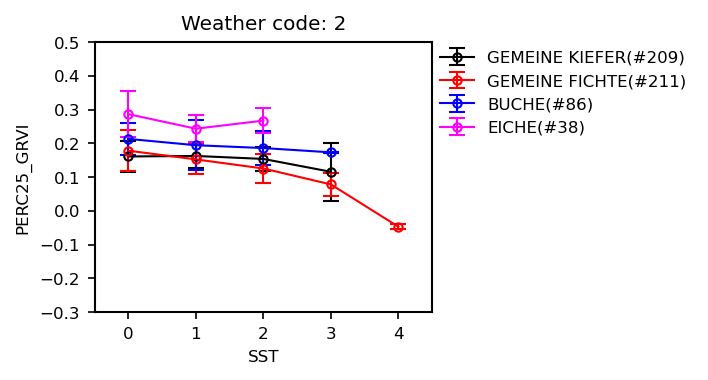

In [464]:
col = 'perc25_grvi'
weather_id = 2
statistics = 'mean'
statistics_err = 'std'

colors = ['k', 'r', 'b', 'magenta']

save_name = f"weather{weather_id}" + '_' + col + '.svg'


################### Plotting 
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.65)
ax = f.add_subplot(111)

for i, (family_id, family) in enumerate(families.items()):
    
    # x-data
    x = np.array(df_grouped.loc[(family_id, weather_id, slice(None)), :].index.get_level_values(2))

    # y-data: Define
    y = df_grouped.loc[(family_id, weather_id, slice(None)), (col, statistics)].values
    yerr = df_grouped.loc[(family_id, weather_id, slice(None)), (col, statistics_err)].values

    # xy-data: Remove NaNs in case of single crown per family
    x = x[np.isfinite(yerr)]
    y = y[np.isfinite(yerr)]
    yerr = yerr[np.isfinite(yerr)]

    # counts
    counts = df_grouped.loc[(family_id, weather_id, slice(None)), (col, 'count')].values
    counts = np.sum(counts)

    ax.errorbar(
        x,
        y,
        yerr,
        label=family['family_name'].upper() + f"(#{counts:.0f})",
        marker='o',
        c=colors[i],
        mec=colors[i],
        mfc='none',
        ms=4,
        capsize=4,
    )

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(f"Weather code: {weather_id}")
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(range(5))
    ax.set_xlabel('SST')
    
    ax.set_ylabel(col.upper())
    ax.set_ylim(-0.3,0.5)

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

#### Groupby: family, weather, nbv

In [465]:
df_grouped = df.groupby(['family', 'weather', 'nbv']).describe()

#### Plot: All families: Single Vegetation Index vs. NBV for different weather conditions

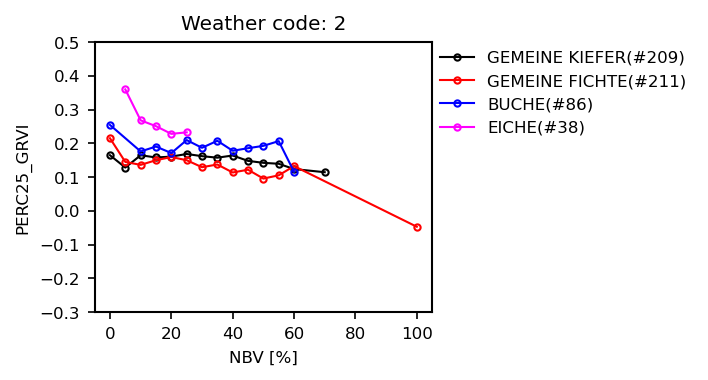

In [482]:
col = 'perc25_grvi'
weather_id = 2
statistics = 'mean'
statistics_err = 'std'

colors = ['k', 'r', 'b', 'magenta']

save_name = f"nbv_weather{weather_id}" + '_' + col + '.svg'


################### Plotting 
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.65)
ax = f.add_subplot(111)

for i, (family_id, family) in enumerate(families.items()):
    
    # x-data
    x = np.array(df_grouped.loc[(family_id, weather_id, slice(None)), :].index.get_level_values(2))

    # y-data: Define
    y = df_grouped.loc[(family_id, weather_id, slice(None)), (col, statistics)].values
    yerr = df_grouped.loc[(family_id, weather_id, slice(None)), (col, statistics_err)].values

    # xy-data: Remove NaNs in case of single crown per family
    x = x[np.isfinite(yerr)]
    y = y[np.isfinite(yerr)]
    yerr = yerr[np.isfinite(yerr)]

    # counts
    counts = df_grouped.loc[(family_id, weather_id, slice(None)), (col, 'count')].values
    counts = np.sum(counts)

    ax.errorbar(
        x,
        y,
#         yerr,
        label=family['family_name'].upper() + f"(#{counts:.0f})",
        marker='o',
        c=colors[i],
        mec=colors[i],
        mfc='none',
        ms=3,
        capsize=4,
    )

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(f"Weather code: {weather_id}")
    
    ax.set_xlim(-5,105)
    ax.set_xlabel(r'NBV [%]')
    
    ax.set_ylabel(col.upper())
    ax.set_ylim(-0.3,0.5)

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

#### Groupby: family, sst

In [511]:
df_grouped = df.groupby(['family', 'sst']).describe()

#### Plot: All families: Single Vegetation Index vs. SST for all weather conditions

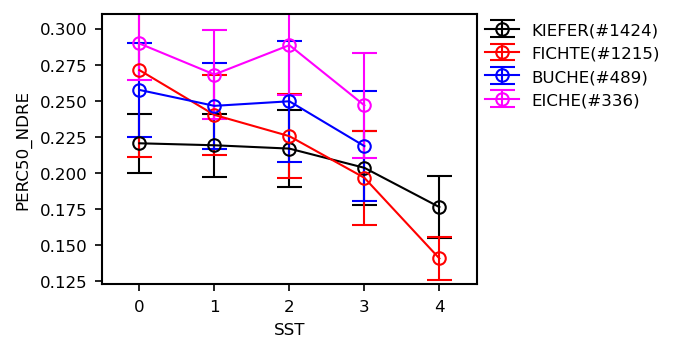

In [562]:
col = 'perc50_ndre'

statistics = 'mean'
statistics_err = 'std'

colors = ['k', 'r', 'b', 'magenta']

save_name = col + '.svg'


################### Plotting 
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.7)
ax = f.add_subplot(111)

for i, (family_id, family) in enumerate(families.items()):
    
    # x-data
    x = np.array(df_grouped.loc[(family_id, slice(None)), :].index.get_level_values(1))

    # y-data: Define
    y = df_grouped.loc[(family_id, slice(None)), (col, statistics)].values
    yerr = df_grouped.loc[(family_id, slice(None)), (col, statistics_err)].values

    # xy-data: Remove NaNs in case of single crown per family
    x = x[np.isfinite(yerr)]
    y = y[np.isfinite(yerr)]
    yerr = yerr[np.isfinite(yerr)]

    # counts
    counts = df_grouped.loc[(family_id, slice(None)), (col, 'count')].values
    counts = np.sum(counts)
    
    ax.errorbar(
        x,
        y,
        yerr,
        label=family['family_name'].upper() + f"(#{counts:.0f})",
        marker='o',
        c=colors[i],
        mec=colors[i],
        mfc='none',
        ms=6,
        capsize=6,
    )

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(range(5))
    ax.set_xlabel('SST')
    
    ax.set_ylabel(col.upper())
    ax.set_ylim(0.123, 0.31)

# plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

#### Groupby: family, sst. Assign width

In [551]:
df = df.assign(ndvi_width = (df.perc95_ndvi - df.perc5_ndvi) * 100 / np.abs(df.perc50_ndvi) )
df = df.assign(ndvire_width = (df.perc95_ndvire - df.perc5_ndvire) * 100 / np.abs(df.perc50_ndvire) )
df = df.assign(grvi_width = (df.perc95_grvi - df.perc5_grvi) * 100 / np.abs(df.perc50_grvi) )
df = df.assign(ndre_width = (df.perc95_ndre - df.perc5_ndre) * 100 / np.abs(df.perc50_ndre) )

df_grouped = df.groupby(['family', 'sst']).describe()

#### Plot: One family: Single Vegetation Index Percentiles vs. SST for all weather conditions

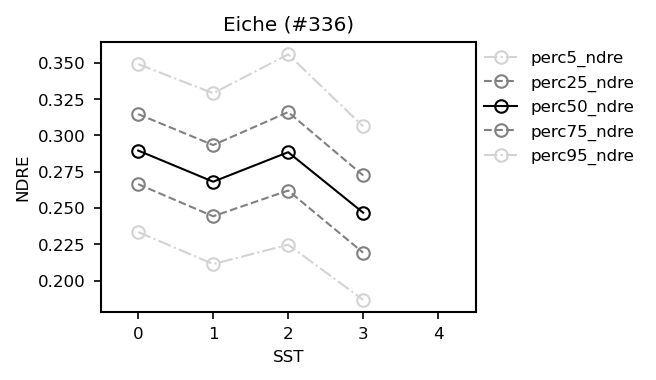

In [548]:
cols = [
#     'perc5_ndvi', 'perc25_ndvi', 'perc50_ndvi', 'perc75_ndvi', 'perc95_ndvi',
#     'perc5_ndvire', 'perc25_ndvire', 'perc50_ndvire', 'perc75_ndvire', 'perc95_ndvire',
#     'perc5_grvi', 'perc25_grvi', 'perc50_grvi', 'perc75_grvi', 'perc95_grvi',
#     'perc5_ndre', 'perc25_ndre', 'perc50_ndre', 'perc75_ndre', 'perc95_ndre',
]

family_id = 3
family_name = families[family_id]['family_name']

statistics = 'mean'
statistics_err = 'std'

colors = ['lightgrey', 'grey', 'k', 'grey', 'lightgrey']
styles = ['-.', '--', '-', '--', '-.']

save_name = family_name.lower() + '_' + cols[0].split('_')[-1] + '.svg'

################### Plotting 
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.7)
ax = f.add_subplot(111)

for i, col in enumerate(cols):
    
    # x-data
    x = np.array(df_grouped.loc[(family_id, slice(None)), col].index.get_level_values(1))
    
    # y-data: Define
    y = df_grouped.loc[(family_id, slice(None)), (col, statistics)].values
    yerr = df_grouped.loc[(family_id, slice(None)), (col, statistics_err)].values
    
    # xy-data: Remove NaNs in case of single crown per family
    x = x[np.isfinite(yerr)]
    y = y[np.isfinite(yerr)]
    yerr = yerr[np.isfinite(yerr)]

    # counts
    counts = df_grouped.loc[(family_id, slice(None)), (col, 'count')].values
    counts = np.sum(counts)
    
    ax.errorbar(
        x,
        y,
#         yerr,
        label=col,
        marker='o',
        c=colors[i],
        ls=styles[i],
        mec=colors[i],
        mfc='none',
        ms=6,
        capsize=6,
    )

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(family_name + f" (#{counts:.0f})")
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(range(5))
    ax.set_xlabel('SST')
    
    ax.set_ylabel(col.split('_')[-1].upper())
#     ax.set_ylim(0.123, 0.31)

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)

#### Plot: One family: Vegetation Indices Width vs. SST for all weather conditions

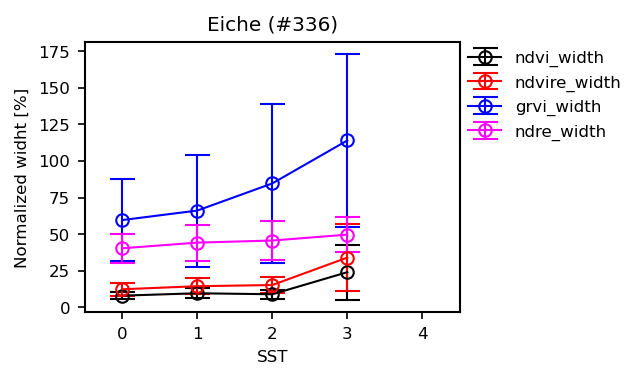

In [560]:
cols = [
    'ndvi_width', 'ndvire_width', 'grvi_width', 'ndre_width'
]

family_id = 3
family_name = families[family_id]['family_name']

statistics = 'mean'
statistics_err = 'std'

colors = ['k', 'r', 'b', 'magenta']

save_name = family_name.lower() + '_width' + '.svg'

################### Plotting 
f = plt.figure(figsize= [5, 3])
f.clear()
f.subplots_adjust(bottom=0.2, top=0.8, left=0.2, right=0.7)
ax = f.add_subplot(111)

for i, col in enumerate(cols):
    
    # x-data
    x = np.array(df_grouped.loc[(family_id, slice(None)), col].index.get_level_values(1))
    
    # y-data: Define
    y = df_grouped.loc[(family_id, slice(None)), (col, statistics)].values
    yerr = df_grouped.loc[(family_id, slice(None)), (col, statistics_err)].values
    
    # xy-data: Remove NaNs in case of single crown per family
    x = x[np.isfinite(yerr)]
    y = y[np.isfinite(yerr)]
    yerr = yerr[np.isfinite(yerr)]

    # counts
    counts = df_grouped.loc[(family_id, slice(None)), (col, 'count')].values
    counts = np.sum(counts)
    
    ax.errorbar(
        x,
        y,
        yerr,
        label=col,
        marker='o',
        c=colors[i],
        mec=colors[i],
        mfc='none',
        ms=6,
        capsize=6,
    )

    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    ax.set_title(family_name + f" (#{counts:.0f})")
    
    ax.set_xlim(-0.5, 4.5)
    ax.set_xticks(range(5))
    ax.set_xlabel('SST')
    
    ax.set_ylabel(r'Normalized widht [%]')
#     ax.set_ylim(0.123, 0.31)

plt.savefig(os.path.join(dir_plots, save_name), transparent=True)